In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML
from tensorflow.keras.applications import DenseNet201

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 224
CHANNELS=3
EPOCHS=3

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "F:\Richa\lungDisease\Training\lungcancer",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 30000 files belonging to 4 classes.


In [4]:
class_names = dataset.class_names
class_names

['Maskimages', 'lung_aca', 'lung_n', 'lung_scc']

In [5]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 224, 224, 3)
[0 0 1 2 2 0 3 2 3 1 2 0 0 0 2 1 0 3 0 3 0 0 3 0 2 2 0 0 2 0 1 0]


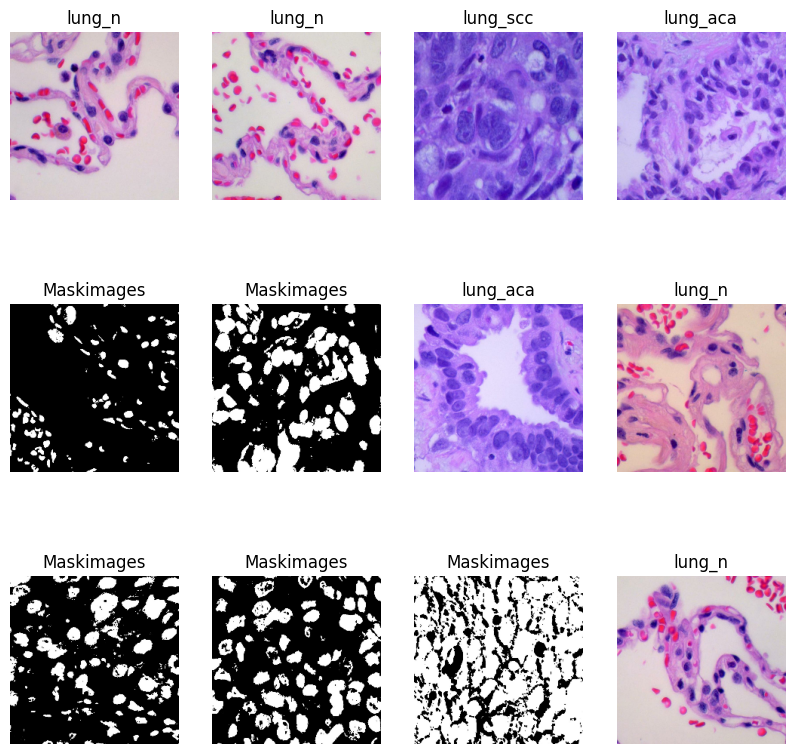

In [6]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [7]:
len(dataset)

938

In [8]:
train_size = 0.8
len(dataset)*train_size

750.4000000000001

In [9]:
train_ds = dataset.take(375)
len(train_ds)

375

In [10]:
test_ds = dataset.skip(375)
len(test_ds)

563

In [11]:
val_size=0.1
len(dataset)*val_size

93.80000000000001

In [12]:
val_ds = test_ds.take(46)
len(val_ds)

46

In [ ]:
test_ds = test_ds.skip(46)
len(test_ds)

In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [ ]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras import layers

# Load pre-trained DenseNet201 model
base_model = DenseNet201(weights='imagenet', include_top=True, input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))

# Freeze the base model layers
base_model.trainable = False
dropout_rate = 0.2
n_classes = 3
layers.Dense(n_classes, activation='softmax'),



In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [ ]:
from keras.callbacks import EarlyStopping

# Create an EarlyStopping callback
early_stopping = EarlyStopping(patience=5, monitor='val_loss')

# Train the model with early stopping
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=3,
    callbacks=[early_stopping]
)


In [ ]:
scores = model.evaluate(test_ds)

In [ ]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[2].numpy().astype('uint8')
    first_label = labels_batch[2].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[2])])
    

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

In [ ]:
from sklearn.metrics import classification_report

# Create empty lists to store predicted labels and actual labels
predicted_labels = []
actual_labels = []

plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(48):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        # Predict the class label for the current image
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        
        # Append predicted and actual labels to the respective lists
        predicted_labels.append(predicted_class)
        actual_labels.append(actual_class)

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

# Generate classification report
report = classification_report(actual_labels, predicted_labels, target_names=class_names)
print(report)
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Generate confusion matrix
cm = confusion_matrix(actual_labels, predicted_labels)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("Actual Labels")
plt.title("Confusion Matrix")

plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have the training history stored in a variable named 'history'
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Plotting the accuracy
epochs = range(1, len(train_accuracy) + 1)
plt.plot(epochs, train_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have the training history stored in a variable named 'history'
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plotting the loss
epochs = range(1, len(train_loss) + 1)
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()